In [1]:
!pip install -q kaggle

In [2]:
!pip uninstall tensorflow
!pip install tensorflow

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
Y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 831.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import tensorflow as tf
print(tf.__version__)

2.17.0


## Import Libraries

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dotenv import load_dotenv

import tensorflow as tf
from keras import models, layers, regularizers, optimizers
from keras.models import Sequential, save_model,load_model
from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.applications import MobileNetV2

from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# %cd /content/drive/My Drive/FYP/

In [6]:
import tensorflow as tf

# Check if GPUs are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPUs available")

print("Num GPUs Available: ", len(gpus))

1 Physical GPUs, 1 Logical GPUs
Num GPUs Available:  1


In [7]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## Data Loading 

In [ ]:
load_dotenv()  # Load environment variables from .env file

username = os.getenv("KAGGLE_USERNAME")
kaggle_key = os.getenv("KAGGLE_KEY")

In [8]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":username,"key":kaggle_key}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d akshitmadan/eyes-open-or-closed

Dataset URL: https://www.kaggle.com/datasets/akshitmadan/eyes-open-or-closed
License(s): unknown
 40% 9.00M/22.6M [00:00<00:00, 19.0MB/s]
100% 22.6M/22.6M [00:00<00:00, 45.2MB/s]


In [10]:
!unzip eyes-open-or-closed.zip -d data

Archive:  eyes-open-or-closed.zip
  inflating: data/dataset/test/Closed_Eyes/s0016_00015_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00016_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00017_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00018_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00019_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00020_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00021_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00022_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00023_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00024_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00025_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00026_1_0_0_0_1_01.png  
  inflating: data/dataset/test/Closed_Eyes/s0016_00027_1_0_0_0_1_01.png  
  in

## Data Processing 

In [11]:
labels = ['close', 'open']

In [12]:
train_dir = "data/dataset/train"
test_dir = "data/dataset/test"

BATCH_SIZE = 32
IMG_SIZE = (256, 256)

# Step 1: Create the initial 70% training, 30% validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3  # 30% for validation
)

# Training data (70% of the data in 'train_dir')
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=True,
    subset='training'  # 70% training
)

# Validation data (30% of the data in 'train_dir')
validation_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=True,
    subset='validation'  # 30% validation
)

# Step 2: Load the test data from 'test_dir'
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data (100% of the data in 'test_dir')
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='binary',
    color_mode="grayscale",
    shuffle=False  # No shuffling for test data
)

Found 2380 images belonging to 2 classes.
Found 1020 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [13]:
train_data.image_shape

(256, 256, 1)

In [14]:
x, y = next(train_data)

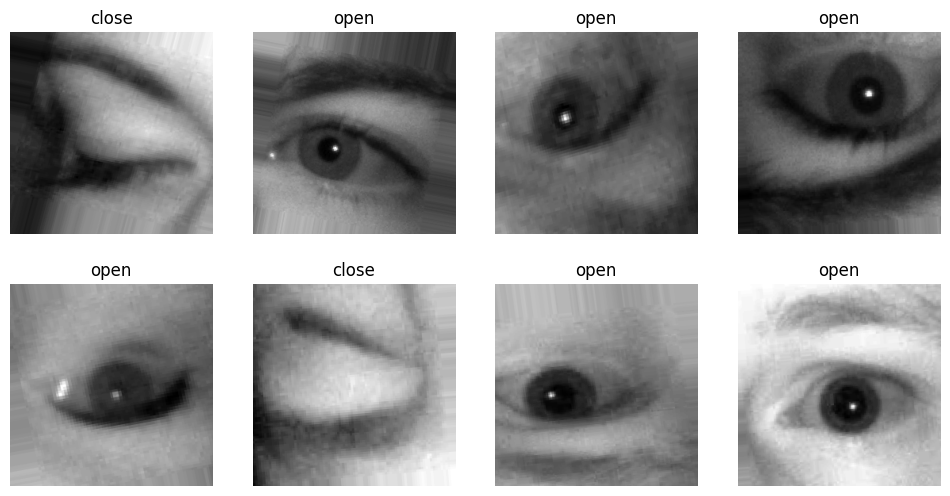

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12,6))
for ax in axs.reshape(-1):
    idx = np.random.randint(x.shape[0])
    ax.set_title(labels[int(y[idx])])
    ax.axis('off')
    image = x[idx]*255
    ax.imshow(image[:,:,0], cmap='gray')

# CNN Model Building

In [17]:
def model():
    model = Sequential()
    model.add(Input(shape=train_data.image_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # dropout regularization
    model.add(Dense(1, activation='sigmoid'))

    return model

In [18]:
cnn = model()
optimizer = optimizers.Adam(learning_rate=0.01)

# Compiling the model
cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      15,745,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,969 (60.13 MB)

 Trainable params: 15,763,969 (60.13 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training 

In [20]:
BATCH_SIZE = 16
EPOCHS = 50
CHANNEL = 1

In [21]:
# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5)

# Training the model
cnn.fit(
    train_data, validation_data=validation_data,
    steps_per_epoch=len(train_data) // 32,
    epochs=EPOCHS,
    callbacks=[reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 14s/step - accuracy: 0.4479 - loss: 21.5597 - val_accuracy: 0.5176 - val_loss: 35.7908 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4792 - loss: 27.3670 - val_accuracy: 0.5176 - val_loss: 1.8737 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 6s/step - accuracy: 0.5177 - loss: 1.8184 - val_accuracy: 0.6363 - val_loss: 0.6824 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4896 - loss: 0.7611 - val_accuracy: 0.5559 - val_loss: 0.6861 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.4375 - loss: 0.7290 - val_accuracy: 0.5618 - val_loss: 0.6884 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5625 - loss: 0.7037
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.5521 - loss: 0.7100 - val_accuracy: 0.5892 - val_loss: 0.6888 -

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 38: ReduceLROnPlateau reducing learning rate to 3.9062499126885086e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8750 - loss: 0.4445 - val_accuracy: 0.8382 - val_loss: 0.4045 - learning_rate: 7.8125e-05
Epoch 39/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 5s/step - accuracy: 0.8021 - loss: 0.4544 - val_accuracy: 0.8304 - val_loss: 0.4070 - learning_rate: 3.9062e-05
Epoch 40/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.8826 - loss: 0.4142 - val_accuracy: 0.8225 - val_loss: 0.4191 - learning_rate: 3.9062e-05
Epoch 41/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8906 - loss: 0.4501
Epoch 41: ReduceLROnPlateau reducing learning rate to 1.9531249563442543e-05.
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.8854 - loss: 0.4563 - val_accuracy: 0.8304 - val_loss: 0.4078 - learning_rate: 3.9062e-05
Epoch 42/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9167 - loss: 0.3611 - val_accuracy: 0.8392 - val_loss: 0.4027 - learning_rate: 1.9531e-05
Epoch 43/50
2/2 ━━━━━━━

### Loss and Accuracy Curves 

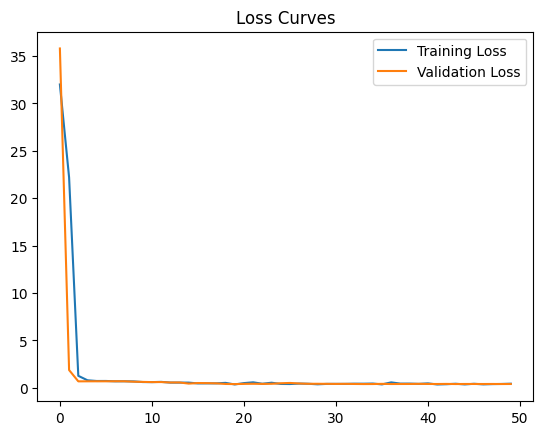

In [22]:
plt.title("Loss Curves")
plt.plot(cnn.history.history['loss'] , label = "Training Loss")
plt.plot(cnn.history.history["val_loss"] , label = "Validation Loss")
plt.legend()

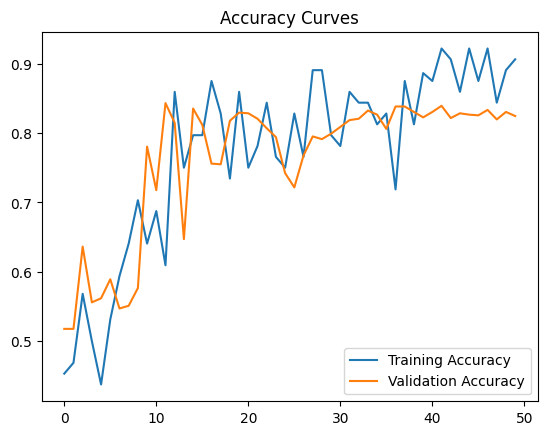

In [23]:
plt.title("Accuracy Curves")
plt.plot(cnn.history.history['accuracy'] , label = "Training Accuracy")
plt.plot(cnn.history.history["val_accuracy"] , label = "Validation Accuracy")
plt.legend()

### Model Evaluation

In [24]:
cnn.evaluate(test_data)

600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8982 - loss: 0.5105


[0.42610979080200195, 0.8566666841506958]

In [25]:
cnn.save("blink_model.keras")

In [26]:
model = load_model("blink_model.keras")

In [27]:
model.evaluate(test_data)

600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8982 - loss: 0.5105


[0.42610979080200195, 0.8566666841506958]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step


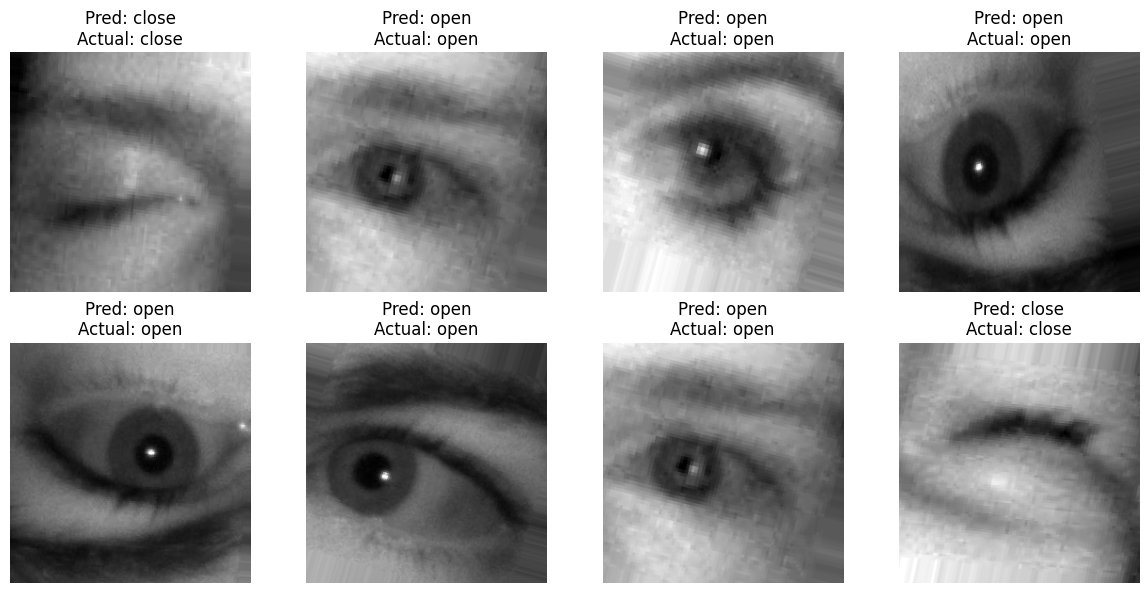

In [29]:
# Load a batch of images and labels from the data
x, y = next(test_data)

# Predict the labels for the batch
predictions = model.predict(x)
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

labels = ['close', 'open']

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
for ax in axs.reshape(-1):
    idx = np.random.randint(x.shape[0])
    actual_label = labels[int(y[idx])]
    predicted_label = labels[int(predicted_labels[idx])]

    ax.set_title(f"Pred: {predicted_label}\nActual: {actual_label}")
    ax.axis('off')
    image = x[idx] * 255
    ax.imshow(image[:, :, 0], cmap='gray')

plt.tight_layout()
plt.show()

## Classification Metrics 

In [30]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")

600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8982 - loss: 0.5105
Test Accuracy: 0.8567


In [31]:
y_true = test_data.classes

predictions = model.predict(test_data)
y_hat = (predictions>0.5).astype(int).reshape(-1)

600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [32]:
# Classification report
print("Classification Report:")
print(classification_report(y_true, y_hat))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.83       240
           1       0.93      0.83      0.87       360

    accuracy                           0.86       600
   macro avg       0.85      0.86      0.85       600
weighted avg       0.87      0.86      0.86       600



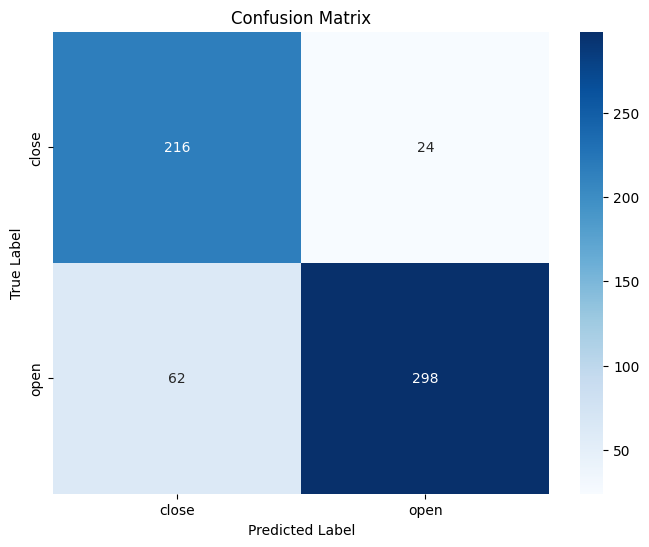

In [33]:
labels = ['close', 'open']
# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()